In [1]:
import cPickle
import numpy as np
import tensorflow as tf

print "loading data..."
x = cPickle.load(open("Data/imdb-train-val-test.pickle", "rb"))

#revs is a list containing tweets and their labels
#word2vec is the pretrained word2vec model
#word_idx_map is the mapping between word and index
revs, word2vec, word_idx_map = x[0], x[1], x[2]
print "data loaded!"

loading data...
data loaded!


In [2]:
#Split data into training, validation and testing
def split_train_valid_test(revs, train_ratio=0.8, valid_ratio=0.05, test_ratio=0.15):
    #revs has been shuffled before, no need to shuffle again
    n_train=int(len(revs)*0.65)
    n_valid=int(len(revs)*0.15)
    train, valid, test=[], [], []
    for i in range(len(revs)):
        if i<n_train:
            train.append(revs[i])
        elif i<n_train+n_valid:
            valid.append(revs[i])
        else:
            test.append(revs[i])
    return train, valid, test

train, valid, test=split_train_valid_test(revs)    
print("Training size {}, validation size {}, test size {}".format(len(train), \
                                                                  len(valid), len(test)))

Training size 130000, validation size 30000, test size 40000


In [3]:
#Knowing the length of tweets is important 
#The length of the input vector depend on it
import pandas as pd
max_sentence_len=np.max((pd.DataFrame(revs)['num_words']))
print("The longest sentence has {} words".format(max_sentence_len))

The longest sentence has 105 words


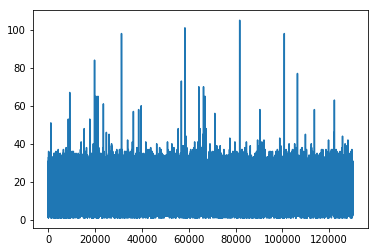

In [7]:
#Most sentecen has length around 35
import matplotlib.pyplot as plt

def count_sentence_length(data):
    n_words=np.zeros(len(data))
    for i in xrange(len(data)):
        n_words[i]=len(data[i]['text'].split())
    return n_words
length_stats=count_sentence_length(train)
plt.plot(length_stats)
plt.show()

In [4]:
# del revs

In [8]:
#Map each word in the sentence to an index
def sentence2_1hot(sentence, word_idx_map, max_length):
    V=np.zeros(shape=max_length, dtype=np.int32)
    i=0
    for word in sentence.split():
        if i>=max_length:
            break
        V[i]=word_idx_map[word]
        i+=1
    return V

In [9]:
#Do embedding
#After this each sentence becomes a matrix of shape = (max_sentence_len, 300)
def embedding_batch(revs, W, word_idx_map, max_sentence_len, batch_size=50, batch_index=0):
    tail=batch_size*(batch_index+1)
    assert tail<=len(revs)
    embedded=np.zeros(shape=(batch_size, max_sentence_len, 300), dtype=np.float64)
    labels=np.zeros(shape=batch_size, dtype=np.int32)
    k=0
    for i in range(tail-batch_size, tail):
        sentence_1hot=sentence2_1hot(revs[i]['text'], word_idx_map, max_sentence_len)
        for j in range(len(sentence_1hot)):
            embedded[k][j][:]=W[sentence_1hot[j]]
        labels[k]=int(revs[i]['y']*0.25)
        k+=1
    return embedded, labels

In [10]:
from tensorflow.contrib.layers import batch_norm
from tensorflow.contrib.layers import fully_connected
import tensorflow as tf 
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import time
from sklearn.base import BaseEstimator, TransformerMixin
he_init = tf.contrib.layers.variance_scaling_initializer()

###############################################################################
#Build a deep neural network with batch normalization, dropout, early stopping
#activation=ELU(exponential linear unit), he initialization, AdamOptimizer
###############################################################################

class My_DNN(BaseEstimator, TransformerMixin):
    def __init__(self, data, W, n_input=30*300, n_output=2, \
                 n_neurons=140, n_layers=5, learning_rate=0.01, n_epoches=1000,\
                 batch_size=200,batch_norm_momentum=0.99, dropout_rate=0.5, \
                 activation=tf.nn.elu, initializer=he_init):
        self.W=W #word2vec
        self.data=data
        self.n_input=n_input
        self.n_output=n_output
        self.n_neurons=n_neurons
        self.n_layers=n_layers
        self.learning_rate=learning_rate
        self.n_epoches=n_epoches
        self.batch_size=batch_size
        self.batch_norm_momentum=batch_norm_momentum
        self.dropout_rate=dropout_rate
        self.activation=activation
        self.initializer=initializer
        self._session = None
    
    def build_hidden_layers(self, input):
        is_training=tf.placeholder_with_default(False, shape=(), name='training')
        for layer in range(self.n_layers-1):
            if(self.dropout_rate!=None):
                input=tf.layers.dropout(input, self.dropout_rate, training=is_training)
            input=tf.layers.dense(input, self.n_neurons, activation=self.activation,\
                                          kernel_initializer=self.initializer)
            if(self.batch_norm_momentum!=None):
                input=tf.layers.batch_normalization(input, momentum=self.batch_norm_momentum, training=is_training)
        self.is_training=is_training
        return input
    
    def build_graph(self):
        X=tf.placeholder(tf.float32, shape=(None, self.n_input), name='tweets')
        y=tf.placeholder(tf.int64, shape=(None), name='sentiment')       
        output=self.build_hidden_layers(X)
        logits=tf.layers.dense(output, self.n_output, activation=tf.nn.softmax, kernel_initializer=self.initializer)
        xentropy=tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
        loss=tf.reduce_mean(xentropy, name='loss')
        optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        training_op=optimizer.minimize(loss)
        correct=tf.nn.in_top_k(logits, y, 1)
        accuracy=tf.reduce_mean(tf.cast(correct, tf.float32))
        Y_prob = tf.nn.softmax(logits, name="Y_proba")
        init=tf.global_variables_initializer()
        saver = tf.train.Saver()
        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._loss, self.Y_prob = loss, Y_prob
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver
        
    def fit(self, X_validation, y_validation):
        n_batches=len(self.data)//self.batch_size
        best_validation_loss=np.infty
        max_checks_no_progress=20
        check_without_process=0
        
        start=time.time()
        self.build_graph()
        self._session = tf.Session()
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(self.n_epoches):
                for batch in range(1, n_batches):
                    #Embedding the whole training data is expensive, here I do it in batch
                    X_batch, y_batch=embedding_batch(self.data, self.W, word_idx_map, 30, \
                                            batch_size=self.batch_size, batch_index=batch)
                    sess.run(self._training_op, feed_dict={self.is_training:True, self._X:X_batch.reshape(self.batch_size,self.n_input), self._y:y_batch.reshape(self.batch_size)})
                batch_training_accuracy=self._accuracy.eval(feed_dict={self.is_training:True, self._X:X_batch.reshape(self.batch_size,self.n_input), self._y:y_batch.reshape(self.batch_size)})
                validation_accuracy=self._accuracy.eval(feed_dict={self.is_training:False, self._X:X_validation.reshape(-1,self.n_input), self._y:y_validation.reshape(-1)})
                validation_loss=self._loss.eval(feed_dict={self.is_training:False, self._X:X_validation.reshape(-1,self.n_input), self._y:y_validation.reshape(-1)})
                print("Epoch:", epoch, "training:", batch_training_accuracy, "validation:", validation_accuracy, \
                      "valid_loss", validation_loss, "best_loss", best_validation_loss)
                if(validation_loss<best_validation_loss):
                    save_path = self._saver.save(sess, "./new_dnn_sentiment.ckpt")
                    best_validation_loss=validation_loss
                    check_without_process=0
                else:
                    check_without_process+=1
                    if check_without_process>=max_checks_no_progress:
                        print("Early stopping!")
                        break;
        end=time.time()
        print("Training completed in {} minutes".format((time.time()-start)/60))
        
    def predict_proba(self, X):
        with self._session.as_default() as sess:
            return self.Y_prob.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X.reshape(-1, self.n_input)), axis=1)
        return np.array(class_indices)

In [11]:
#Embedding the whole training data is expensive, I do it in batch inside My_DNN.fit()
#Here I only embed validation set and testing set
X_validation, y_validation=embedding_batch(valid, word2vec, word_idx_map, 30, \
                                            batch_size=5000, batch_index=0)

In [ ]:
#Use scikit learn grid search to tune parameters
#Training is very expensive on my laptop without GPU support
from sklearn.model_selection import GridSearchCV
import time

#del valid
params = {
    "n_neurons": [100, 150, 250],
    "batch_size": [64, 128],
    "learning_rate": [0.01, 0.001],
#     "activation": [tf.nn.relu, tf.nn.elu],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    "n_layers": [3,5,7,9],
#     "batch_norm_momentum": [0.99, None],
#     "dropout_rate":[0.4, 0.5, 0.6, None],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}
start=time.time()
rnd_dnn_clf=My_DNN(data=train, W=word2vec, n_epoches=500, batch_norm_momentum=0.99, dropout_rate=0.5)

rnd_search = GridSearchCV(rnd_dnn_clf, param_grid = params, scoring='f1', verbose=2)
rnd_search.fit(X_validation, y_validation)
print("*******************************************************")
print("Complete in {} minutes".format((time.time()-start)/60))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] learning_rate=0.01, n_layers=3, n_neurons=100, batch_size=64 ....
('Epoch:', 0, 'training:', 0.734375, 'validation:', 0.63126314, 'valid_loss', 0.67676961, 'best_loss', inf)
('Epoch:', 1, 'training:', 0.65625, 'validation:', 0.66336632, 'valid_loss', 0.64863241, 'best_loss', 0.67676961)
('Epoch:', 2, 'training:', 0.71875, 'validation:', 0.67656767, 'valid_loss', 0.63635153, 'best_loss', 0.64863241)
('Epoch:', 3, 'training:', 0.6875, 'validation:', 0.67626762, 'valid_loss', 0.63609034, 'best_loss', 0.63635153)
('Epoch:', 4, 'training:', 0.734375, 'validation:', 0.69276929, 'valid_loss', 0.61935794, 'best_loss', 0.63609034)
('Epoch:', 5, 'training:', 0.78125, 'validation:', 0.66726673, 'valid_loss', 0.64603835, 'best_loss', 0.61935794)
('Epoch:', 6, 'training:', 0.78125, 'validation:', 0.6870687, 'valid_loss', 0.62603199, 'best_loss', 0.61935794)
('Epoch:', 7, 'training:', 0.828125, 'validation:', 0.66666669, 'valid_loss'

('Epoch:', 71, 'training:', 0.828125, 'validation:', 0.72757274, 'valid_loss', 0.58568579, 'best_loss', 0.57050318)
('Epoch:', 72, 'training:', 0.828125, 'validation:', 0.73537356, 'valid_loss', 0.57788932, 'best_loss', 0.57050318)
('Epoch:', 73, 'training:', 0.828125, 'validation:', 0.72427243, 'valid_loss', 0.58892149, 'best_loss', 0.57050318)
('Epoch:', 74, 'training:', 0.875, 'validation:', 0.72997302, 'valid_loss', 0.5832898, 'best_loss', 0.57050318)
('Epoch:', 75, 'training:', 0.859375, 'validation:', 0.72607261, 'valid_loss', 0.58719027, 'best_loss', 0.57050318)
('Epoch:', 76, 'training:', 0.90625, 'validation:', 0.73087311, 'valid_loss', 0.58238971, 'best_loss', 0.57050318)
('Epoch:', 77, 'training:', 0.734375, 'validation:', 0.72817284, 'valid_loss', 0.5850895, 'best_loss', 0.57050318)
('Epoch:', 78, 'training:', 0.921875, 'validation:', 0.72787279, 'valid_loss', 0.58546072, 'best_loss', 0.57050318)
('Epoch:', 79, 'training:', 0.78125, 'validation:', 0.73327333, 'valid_loss', 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 60.3min remaining:    0.0s


[CV] learning_rate=0.01, n_layers=3, n_neurons=100, batch_size=64 ....
('Epoch:', 0, 'training:', 0.640625, 'validation:', 0.65346533, 'valid_loss', 0.65339291, 'best_loss', inf)
('Epoch:', 1, 'training:', 0.78125, 'validation:', 0.64146417, 'valid_loss', 0.66925889, 'best_loss', 0.65339291)
('Epoch:', 2, 'training:', 0.71875, 'validation:', 0.65166515, 'valid_loss', 0.66142589, 'best_loss', 0.65339291)
('Epoch:', 3, 'training:', 0.734375, 'validation:', 0.66216624, 'valid_loss', 0.65095192, 'best_loss', 0.65339291)
('Epoch:', 4, 'training:', 0.6875, 'validation:', 0.68976897, 'valid_loss', 0.62278867, 'best_loss', 0.65095192)
('Epoch:', 5, 'training:', 0.71875, 'validation:', 0.69216919, 'valid_loss', 0.62146169, 'best_loss', 0.62278867)
('Epoch:', 6, 'training:', 0.71875, 'validation:', 0.68526852, 'valid_loss', 0.6275757, 'best_loss', 0.62146169)
('Epoch:', 7, 'training:', 0.78125, 'validation:', 0.68586856, 'valid_loss', 0.62710583, 'best_loss', 0.62146169)
('Epoch:', 8, 'training:

('Epoch:', 71, 'training:', 0.78125, 'validation:', 0.74797481, 'valid_loss', 0.56528801, 'best_loss', 0.55898738)
('Epoch:', 72, 'training:', 0.875, 'validation:', 0.74617463, 'valid_loss', 0.56688595, 'best_loss', 0.55898738)
('Epoch:', 73, 'training:', 0.796875, 'validation:', 0.74347436, 'valid_loss', 0.56977868, 'best_loss', 0.55898738)
('Epoch:', 74, 'training:', 0.734375, 'validation:', 0.75277525, 'valid_loss', 0.56048417, 'best_loss', 0.55898738)
('Epoch:', 75, 'training:', 0.8125, 'validation:', 0.74617463, 'valid_loss', 0.56700277, 'best_loss', 0.55898738)
('Epoch:', 76, 'training:', 0.8125, 'validation:', 0.74947494, 'valid_loss', 0.56378782, 'best_loss', 0.55898738)
('Epoch:', 77, 'training:', 0.875, 'validation:', 0.75097507, 'valid_loss', 0.56228781, 'best_loss', 0.55898738)
('Epoch:', 78, 'training:', 0.828125, 'validation:', 0.75337535, 'valid_loss', 0.55988753, 'best_loss', 0.55898738)
('Epoch:', 79, 'training:', 0.8125, 'validation:', 0.75697571, 'valid_loss', 0.5563

('Epoch:', 32, 'training:', 0.765625, 'validation:', 0.74565089, 'valid_loss', 0.56761217, 'best_loss', 0.56145895)
('Epoch:', 33, 'training:', 0.765625, 'validation:', 0.74475104, 'valid_loss', 0.56844676, 'best_loss', 0.56145895)
('Epoch:', 34, 'training:', 0.859375, 'validation:', 0.74775046, 'valid_loss', 0.56552613, 'best_loss', 0.56145895)
('Epoch:', 35, 'training:', 0.796875, 'validation:', 0.73935211, 'valid_loss', 0.57392704, 'best_loss', 0.56145895)
('Epoch:', 36, 'training:', 0.703125, 'validation:', 0.74895018, 'valid_loss', 0.56431228, 'best_loss', 0.56145895)
('Epoch:', 37, 'training:', 0.875, 'validation:', 0.74325132, 'valid_loss', 0.56982404, 'best_loss', 0.56145895)
('Epoch:', 38, 'training:', 0.8125, 'validation:', 0.74895018, 'valid_loss', 0.56431252, 'best_loss', 0.56145895)
('Epoch:', 39, 'training:', 0.75, 'validation:', 0.75074983, 'valid_loss', 0.56226897, 'best_loss', 0.56145895)
('Epoch:', 40, 'training:', 0.828125, 'validation:', 0.74715054, 'valid_loss', 0.

('Epoch:', 29, 'training:', 0.75, 'validation:', 0.70657068, 'valid_loss', 0.60668981, 'best_loss', 0.59415317)
('Epoch:', 30, 'training:', 0.671875, 'validation:', 0.71407139, 'valid_loss', 0.59919143, 'best_loss', 0.59415317)
('Epoch:', 31, 'training:', 0.828125, 'validation:', 0.70537055, 'valid_loss', 0.60789198, 'best_loss', 0.59415317)
('Epoch:', 32, 'training:', 0.734375, 'validation:', 0.70627064, 'valid_loss', 0.60699189, 'best_loss', 0.59415317)
('Epoch:', 33, 'training:', 0.765625, 'validation:', 0.70207024, 'valid_loss', 0.61119676, 'best_loss', 0.59415317)
('Epoch:', 34, 'training:', 0.796875, 'validation:', 0.71287131, 'valid_loss', 0.60043293, 'best_loss', 0.59415317)
('Epoch:', 35, 'training:', 0.78125, 'validation:', 0.70537055, 'valid_loss', 0.60789186, 'best_loss', 0.59415317)
('Epoch:', 36, 'training:', 0.796875, 'validation:', 0.71287131, 'valid_loss', 0.60039127, 'best_loss', 0.59415317)
('Epoch:', 37, 'training:', 0.75, 'validation:', 0.7050705, 'valid_loss', 0.6

('Epoch:', 30, 'training:', 0.84375, 'validation:', 0.70837086, 'valid_loss', 0.60489178, 'best_loss', 0.59517485)
('Epoch:', 31, 'training:', 0.8125, 'validation:', 0.72187221, 'valid_loss', 0.59127206, 'best_loss', 0.59517485)
('Epoch:', 32, 'training:', 0.6875, 'validation:', 0.69456947, 'valid_loss', 0.61870182, 'best_loss', 0.59127206)
('Epoch:', 33, 'training:', 0.796875, 'validation:', 0.70357037, 'valid_loss', 0.6096921, 'best_loss', 0.59127206)
('Epoch:', 34, 'training:', 0.71875, 'validation:', 0.70987099, 'valid_loss', 0.60339159, 'best_loss', 0.59127206)
('Epoch:', 35, 'training:', 0.859375, 'validation:', 0.71587157, 'valid_loss', 0.59749943, 'best_loss', 0.59127206)
('Epoch:', 36, 'training:', 0.78125, 'validation:', 0.72307229, 'valid_loss', 0.59016055, 'best_loss', 0.59127206)
('Epoch:', 37, 'training:', 0.765625, 'validation:', 0.70297033, 'valid_loss', 0.61029232, 'best_loss', 0.59016055)
('Epoch:', 38, 'training:', 0.796875, 'validation:', 0.72097212, 'valid_loss', 0

('Epoch:', 31, 'training:', 0.8125, 'validation:', 0.74055189, 'valid_loss', 0.57263267, 'best_loss', 0.571217)
('Epoch:', 32, 'training:', 0.796875, 'validation:', 0.74355131, 'valid_loss', 0.56975055, 'best_loss', 0.571217)
('Epoch:', 33, 'training:', 0.8125, 'validation:', 0.73845232, 'valid_loss', 0.57480437, 'best_loss', 0.56975055)
('Epoch:', 34, 'training:', 0.796875, 'validation:', 0.73995203, 'valid_loss', 0.57331079, 'best_loss', 0.56975055)
('Epoch:', 35, 'training:', 0.828125, 'validation:', 0.74175167, 'valid_loss', 0.57156587, 'best_loss', 0.56975055)
('Epoch:', 36, 'training:', 0.828125, 'validation:', 0.73815238, 'valid_loss', 0.57511699, 'best_loss', 0.56975055)
('Epoch:', 37, 'training:', 0.765625, 'validation:', 0.74385124, 'valid_loss', 0.56941158, 'best_loss', 0.56975055)
('Epoch:', 38, 'training:', 0.765625, 'validation:', 0.73425317, 'valid_loss', 0.57901138, 'best_loss', 0.56941158)
('Epoch:', 39, 'training:', 0.78125, 'validation:', 0.73605281, 'valid_loss', 0.

('Epoch:', 103, 'training:', 0.8125, 'validation:', 0.75464904, 'valid_loss', 0.55861372, 'best_loss', 0.56071335)
('Epoch:', 104, 'training:', 0.828125, 'validation:', 0.74475104, 'valid_loss', 0.56851178, 'best_loss', 0.55861372)
('Epoch:', 105, 'training:', 0.796875, 'validation:', 0.7396521, 'valid_loss', 0.57361072, 'best_loss', 0.55861372)
('Epoch:', 106, 'training:', 0.796875, 'validation:', 0.74745053, 'valid_loss', 0.56581229, 'best_loss', 0.55861372)
('Epoch:', 107, 'training:', 0.90625, 'validation:', 0.74805039, 'valid_loss', 0.56521243, 'best_loss', 0.55861372)
('Epoch:', 108, 'training:', 0.75, 'validation:', 0.74625075, 'valid_loss', 0.56701207, 'best_loss', 0.55861372)
('Epoch:', 109, 'training:', 0.84375, 'validation:', 0.75014997, 'valid_loss', 0.56311285, 'best_loss', 0.55861372)
('Epoch:', 110, 'training:', 0.875, 'validation:', 0.74985003, 'valid_loss', 0.56341279, 'best_loss', 0.55861372)
('Epoch:', 111, 'training:', 0.875, 'validation:', 0.73215359, 'valid_loss',

('Epoch:', 4, 'training:', 0.734375, 'validation:', 0.69726974, 'valid_loss', 0.61594611, 'best_loss', 0.63265741)
('Epoch:', 5, 'training:', 0.859375, 'validation:', 0.70117015, 'valid_loss', 0.61147928, 'best_loss', 0.61594611)
('Epoch:', 6, 'training:', 0.8125, 'validation:', 0.70237023, 'valid_loss', 0.61084437, 'best_loss', 0.61147928)
('Epoch:', 7, 'training:', 0.84375, 'validation:', 0.71197122, 'valid_loss', 0.6012857, 'best_loss', 0.61084437)
('Epoch:', 8, 'training:', 0.6875, 'validation:', 0.71347135, 'valid_loss', 0.59956384, 'best_loss', 0.6012857)
('Epoch:', 9, 'training:', 0.8125, 'validation:', 0.71617162, 'valid_loss', 0.59708482, 'best_loss', 0.59956384)
('Epoch:', 10, 'training:', 0.8125, 'validation:', 0.71047103, 'valid_loss', 0.60280007, 'best_loss', 0.59708482)
('Epoch:', 11, 'training:', 0.875, 'validation:', 0.72577256, 'valid_loss', 0.58737803, 'best_loss', 0.59708482)
('Epoch:', 12, 'training:', 0.765625, 'validation:', 0.72247225, 'valid_loss', 0.59080213, '

('Epoch:', 25, 'training:', 0.8125, 'validation:', 0.71235752, 'valid_loss', 0.60090703, 'best_loss', 0.57958192)
('Epoch:', 26, 'training:', 0.8125, 'validation:', 0.72405517, 'valid_loss', 0.58920765, 'best_loss', 0.57958192)
('Epoch:', 27, 'training:', 0.703125, 'validation:', 0.71025795, 'valid_loss', 0.60300487, 'best_loss', 0.57958192)
('Epoch:', 28, 'training:', 0.796875, 'validation:', 0.72645473, 'valid_loss', 0.58680809, 'best_loss', 0.57958192)
('Epoch:', 29, 'training:', 0.78125, 'validation:', 0.72405517, 'valid_loss', 0.58920765, 'best_loss', 0.57958192)
('Epoch:', 30, 'training:', 0.796875, 'validation:', 0.72585481, 'valid_loss', 0.58740801, 'best_loss', 0.57958192)
('Epoch:', 31, 'training:', 0.765625, 'validation:', 0.72225553, 'valid_loss', 0.59100723, 'best_loss', 0.57958192)
('Epoch:', 32, 'training:', 0.75, 'validation:', 0.71235752, 'valid_loss', 0.6009053, 'best_loss', 0.57958192)
('Epoch:', 33, 'training:', 0.828125, 'validation:', 0.71895623, 'valid_loss', 0.5

('Epoch:', 53, 'training:', 0.78125, 'validation:', 0.72727275, 'valid_loss', 0.58599001, 'best_loss', 0.5832898)
('Epoch:', 54, 'training:', 0.890625, 'validation:', 0.72847283, 'valid_loss', 0.58478987, 'best_loss', 0.5832898)
('Epoch:', 55, 'training:', 0.796875, 'validation:', 0.72667265, 'valid_loss', 0.58659017, 'best_loss', 0.5832898)
('Epoch:', 56, 'training:', 0.859375, 'validation:', 0.72637266, 'valid_loss', 0.58689016, 'best_loss', 0.5832898)
('Epoch:', 57, 'training:', 0.828125, 'validation:', 0.72727275, 'valid_loss', 0.58599007, 'best_loss', 0.5832898)
('Epoch:', 58, 'training:', 0.859375, 'validation:', 0.73087311, 'valid_loss', 0.58238971, 'best_loss', 0.5832898)
('Epoch:', 59, 'training:', 0.78125, 'validation:', 0.72577256, 'valid_loss', 0.58749026, 'best_loss', 0.58238971)
('Epoch:', 60, 'training:', 0.890625, 'validation:', 0.7227723, 'valid_loss', 0.59049046, 'best_loss', 0.58238971)
('Epoch:', 61, 'training:', 0.8125, 'validation:', 0.71557158, 'valid_loss', 0.59

('Epoch:', 35, 'training:', 0.859375, 'validation:', 0.74797481, 'valid_loss', 0.56528801, 'best_loss', 0.55868739)
('Epoch:', 36, 'training:', 0.78125, 'validation:', 0.7488749, 'valid_loss', 0.56438792, 'best_loss', 0.55868739)
('Epoch:', 37, 'training:', 0.8125, 'validation:', 0.74977499, 'valid_loss', 0.56348783, 'best_loss', 0.55868739)
('Epoch:', 38, 'training:', 0.765625, 'validation:', 0.75157517, 'valid_loss', 0.56168765, 'best_loss', 0.55868739)
('Epoch:', 39, 'training:', 0.78125, 'validation:', 0.74677467, 'valid_loss', 0.56648815, 'best_loss', 0.55868739)
('Epoch:', 40, 'training:', 0.75, 'validation:', 0.75037503, 'valid_loss', 0.56288779, 'best_loss', 0.55868739)
('Epoch:', 41, 'training:', 0.78125, 'validation:', 0.7578758, 'valid_loss', 0.55538702, 'best_loss', 0.55868739)
('Epoch:', 42, 'training:', 0.71875, 'validation:', 0.75157517, 'valid_loss', 0.56168765, 'best_loss', 0.55538702)
('Epoch:', 43, 'training:', 0.84375, 'validation:', 0.75337535, 'valid_loss', 0.5598

('Epoch:', 43, 'training:', 0.84375, 'validation:', 0.74985003, 'valid_loss', 0.56341279, 'best_loss', 0.56131321)
('Epoch:', 44, 'training:', 0.84375, 'validation:', 0.75404918, 'valid_loss', 0.55921364, 'best_loss', 0.56131321)
('Epoch:', 45, 'training:', 0.8125, 'validation:', 0.75704861, 'valid_loss', 0.55621421, 'best_loss', 0.55921364)
('Epoch:', 46, 'training:', 0.796875, 'validation:', 0.75224954, 'valid_loss', 0.56101328, 'best_loss', 0.55621421)
('Epoch:', 47, 'training:', 0.796875, 'validation:', 0.75944811, 'valid_loss', 0.55381471, 'best_loss', 0.55621421)
('Epoch:', 48, 'training:', 0.875, 'validation:', 0.7603479, 'valid_loss', 0.55291486, 'best_loss', 0.55381471)
('Epoch:', 49, 'training:', 0.796875, 'validation:', 0.75764847, 'valid_loss', 0.55561435, 'best_loss', 0.55291486)
('Epoch:', 50, 'training:', 0.796875, 'validation:', 0.75464904, 'valid_loss', 0.55861372, 'best_loss', 0.55291486)
('Epoch:', 51, 'training:', 0.875, 'validation:', 0.75944811, 'valid_loss', 0.55

('Epoch:', 44, 'training:', 0.84375, 'validation:', 0.73147315, 'valid_loss', 0.58178967, 'best_loss', 0.574889)
('Epoch:', 45, 'training:', 0.8125, 'validation:', 0.73237324, 'valid_loss', 0.58088958, 'best_loss', 0.574889)
('Epoch:', 46, 'training:', 0.75, 'validation:', 0.73357338, 'valid_loss', 0.57968944, 'best_loss', 0.574889)
('Epoch:', 47, 'training:', 0.796875, 'validation:', 0.73057306, 'valid_loss', 0.5826897, 'best_loss', 0.574889)
('Epoch:', 48, 'training:', 0.84375, 'validation:', 0.72967297, 'valid_loss', 0.58358985, 'best_loss', 0.574889)
('Epoch:', 49, 'training:', 0.796875, 'validation:', 0.73237324, 'valid_loss', 0.58088958, 'best_loss', 0.574889)
('Epoch:', 50, 'training:', 0.828125, 'validation:', 0.72787279, 'valid_loss', 0.58538997, 'best_loss', 0.574889)
('Epoch:', 51, 'training:', 0.8125, 'validation:', 0.72667265, 'valid_loss', 0.58658999, 'best_loss', 0.574889)
('Epoch:', 52, 'training:', 0.8125, 'validation:', 0.73837382, 'valid_loss', 0.574889, 'best_loss',

('Epoch:', 53, 'training:', 0.84375, 'validation:', 0.74647462, 'valid_loss', 0.5667882, 'best_loss', 0.5571872)
('Epoch:', 54, 'training:', 0.859375, 'validation:', 0.74857485, 'valid_loss', 0.56468797, 'best_loss', 0.5571872)
('Epoch:', 55, 'training:', 0.828125, 'validation:', 0.74707472, 'valid_loss', 0.5661881, 'best_loss', 0.5571872)
Early stopping!
Training completed in 43.5944461187 minutes
[CV]  learning_rate=0.01, n_layers=5, n_neurons=150, batch_size=64, total=43.6min
[CV] learning_rate=0.01, n_layers=5, n_neurons=150, batch_size=64 ....
('Epoch:', 0, 'training:', 0.625, 'validation:', 0.62687463, 'valid_loss', 0.68603128, 'best_loss', inf)
('Epoch:', 1, 'training:', 0.71875, 'validation:', 0.63077384, 'valid_loss', 0.68255317, 'best_loss', 0.68603128)
('Epoch:', 2, 'training:', 0.8125, 'validation:', 0.64637071, 'valid_loss', 0.66688997, 'best_loss', 0.68255317)
('Epoch:', 3, 'training:', 0.78125, 'validation:', 0.65326935, 'valid_loss', 0.6599915, 'best_loss', 0.66688997)


('Epoch:', 67, 'training:', 0.828125, 'validation:', 0.74445111, 'valid_loss', 0.56881171, 'best_loss', 0.557414)
('Epoch:', 68, 'training:', 0.796875, 'validation:', 0.74985003, 'valid_loss', 0.56341279, 'best_loss', 0.557414)
('Epoch:', 69, 'training:', 0.75, 'validation:', 0.75164968, 'valid_loss', 0.56161314, 'best_loss', 0.557414)
('Epoch:', 70, 'training:', 0.859375, 'validation:', 0.75344932, 'valid_loss', 0.5598135, 'best_loss', 0.557414)
('Epoch:', 71, 'training:', 0.84375, 'validation:', 0.75014997, 'valid_loss', 0.56311285, 'best_loss', 0.557414)
('Epoch:', 72, 'training:', 0.828125, 'validation:', 0.75554889, 'valid_loss', 0.55771393, 'best_loss', 0.557414)
('Epoch:', 73, 'training:', 0.890625, 'validation:', 0.75344932, 'valid_loss', 0.5598135, 'best_loss', 0.557414)
('Epoch:', 74, 'training:', 0.8125, 'validation:', 0.75464904, 'valid_loss', 0.55861372, 'best_loss', 0.557414)
('Epoch:', 75, 'training:', 0.90625, 'validation:', 0.75554889, 'valid_loss', 0.55771393, 'best_l

('Epoch:', 13, 'training:', 0.703125, 'validation:', 0.70147014, 'valid_loss', 0.61179239, 'best_loss', 0.62319332)
('Epoch:', 14, 'training:', 0.796875, 'validation:', 0.69726974, 'valid_loss', 0.61599284, 'best_loss', 0.61179239)
('Epoch:', 15, 'training:', 0.84375, 'validation:', 0.7131713, 'valid_loss', 0.60009152, 'best_loss', 0.61179239)
('Epoch:', 16, 'training:', 0.828125, 'validation:', 0.70477051, 'valid_loss', 0.60849214, 'best_loss', 0.60009152)
('Epoch:', 17, 'training:', 0.796875, 'validation:', 0.69816983, 'valid_loss', 0.61509275, 'best_loss', 0.60009152)
('Epoch:', 18, 'training:', 0.75, 'validation:', 0.71527153, 'valid_loss', 0.59799117, 'best_loss', 0.60009152)
('Epoch:', 19, 'training:', 0.703125, 'validation:', 0.71617162, 'valid_loss', 0.59709108, 'best_loss', 0.59799117)
('Epoch:', 20, 'training:', 0.84375, 'validation:', 0.70987099, 'valid_loss', 0.60339177, 'best_loss', 0.59709108)
('Epoch:', 21, 'training:', 0.8125, 'validation:', 0.70627064, 'valid_loss', 0.

('Epoch:', 21, 'training:', 0.796875, 'validation:', 0.71445709, 'valid_loss', 0.59880573, 'best_loss', 0.57960951)
('Epoch:', 22, 'training:', 0.8125, 'validation:', 0.72375524, 'valid_loss', 0.58950758, 'best_loss', 0.57960951)
('Epoch:', 23, 'training:', 0.78125, 'validation:', 0.72345531, 'valid_loss', 0.58980751, 'best_loss', 0.57960951)
('Epoch:', 24, 'training:', 0.84375, 'validation:', 0.72525495, 'valid_loss', 0.58800787, 'best_loss', 0.57960951)
('Epoch:', 25, 'training:', 0.828125, 'validation:', 0.72915417, 'valid_loss', 0.58410865, 'best_loss', 0.57960951)
('Epoch:', 26, 'training:', 0.828125, 'validation:', 0.73485303, 'valid_loss', 0.57840979, 'best_loss', 0.57960951)
('Epoch:', 27, 'training:', 0.75, 'validation:', 0.7345531, 'valid_loss', 0.57870972, 'best_loss', 0.57840979)
('Epoch:', 28, 'training:', 0.8125, 'validation:', 0.74655068, 'valid_loss', 0.56671214, 'best_loss', 0.57840979)
('Epoch:', 29, 'training:', 0.84375, 'validation:', 0.75014997, 'valid_loss', 0.563

('Epoch:', 36, 'training:', 0.78125, 'validation:', 0.72967297, 'valid_loss', 0.58358979, 'best_loss', 0.57518899)
('Epoch:', 37, 'training:', 0.78125, 'validation:', 0.73537356, 'valid_loss', 0.57788926, 'best_loss', 0.57518899)
('Epoch:', 38, 'training:', 0.78125, 'validation:', 0.73687369, 'valid_loss', 0.57638913, 'best_loss', 0.57518899)
('Epoch:', 39, 'training:', 0.828125, 'validation:', 0.73867387, 'valid_loss', 0.57458895, 'best_loss', 0.57518899)
('Epoch:', 40, 'training:', 0.765625, 'validation:', 0.73837382, 'valid_loss', 0.574889, 'best_loss', 0.57458895)
('Epoch:', 41, 'training:', 0.75, 'validation:', 0.73507351, 'valid_loss', 0.57818931, 'best_loss', 0.57458895)
('Epoch:', 42, 'training:', 0.890625, 'validation:', 0.73357338, 'valid_loss', 0.57968944, 'best_loss', 0.57458895)
('Epoch:', 43, 'training:', 0.78125, 'validation:', 0.7359736, 'valid_loss', 0.57728922, 'best_loss', 0.57458895)
('Epoch:', 44, 'training:', 0.796875, 'validation:', 0.73447347, 'valid_loss', 0.57

('Epoch:', 35, 'training:', 0.734375, 'validation:', 0.7488749, 'valid_loss', 0.56438792, 'best_loss', 0.56588811)
('Epoch:', 36, 'training:', 0.71875, 'validation:', 0.73507351, 'valid_loss', 0.57818931, 'best_loss', 0.56438792)
('Epoch:', 37, 'training:', 0.796875, 'validation:', 0.74287426, 'valid_loss', 0.57038856, 'best_loss', 0.56438792)
('Epoch:', 38, 'training:', 0.796875, 'validation:', 0.73987401, 'valid_loss', 0.57338881, 'best_loss', 0.56438792)
('Epoch:', 39, 'training:', 0.8125, 'validation:', 0.73987401, 'valid_loss', 0.57338881, 'best_loss', 0.56438792)
('Epoch:', 40, 'training:', 0.6875, 'validation:', 0.73927391, 'valid_loss', 0.57398891, 'best_loss', 0.56438792)
('Epoch:', 41, 'training:', 0.796875, 'validation:', 0.73837382, 'valid_loss', 0.574889, 'best_loss', 0.56438792)
('Epoch:', 42, 'training:', 0.84375, 'validation:', 0.73747373, 'valid_loss', 0.57578909, 'best_loss', 0.56438792)
('Epoch:', 43, 'training:', 0.859375, 'validation:', 0.73327333, 'valid_loss', 0.

('Epoch:', 37, 'training:', 0.828125, 'validation:', 0.7420516, 'valid_loss', 0.57121122, 'best_loss', 0.56551236)
('Epoch:', 38, 'training:', 0.796875, 'validation:', 0.74265146, 'valid_loss', 0.57061136, 'best_loss', 0.56551236)
('Epoch:', 39, 'training:', 0.8125, 'validation:', 0.74685061, 'valid_loss', 0.56641221, 'best_loss', 0.56551236)
('Epoch:', 40, 'training:', 0.796875, 'validation:', 0.74505097, 'valid_loss', 0.56821179, 'best_loss', 0.56551236)
('Epoch:', 41, 'training:', 0.84375, 'validation:', 0.74145168, 'valid_loss', 0.57181108, 'best_loss', 0.56551236)
('Epoch:', 42, 'training:', 0.78125, 'validation:', 0.74685061, 'valid_loss', 0.56641221, 'best_loss', 0.56551236)
('Epoch:', 43, 'training:', 0.828125, 'validation:', 0.74295139, 'valid_loss', 0.57031143, 'best_loss', 0.56551236)
('Epoch:', 44, 'training:', 0.796875, 'validation:', 0.75134975, 'valid_loss', 0.56191307, 'best_loss', 0.56551236)
('Epoch:', 45, 'training:', 0.875, 'validation:', 0.75494903, 'valid_loss', 0

('Epoch:', 39, 'training:', 0.75, 'validation:', 0.71467149, 'valid_loss', 0.59859133, 'best_loss', 0.58599007)
('Epoch:', 40, 'training:', 0.78125, 'validation:', 0.71617162, 'valid_loss', 0.5970912, 'best_loss', 0.58599007)
('Epoch:', 41, 'training:', 0.828125, 'validation:', 0.72607261, 'valid_loss', 0.58719021, 'best_loss', 0.58599007)
('Epoch:', 42, 'training:', 0.75, 'validation:', 0.72727275, 'valid_loss', 0.58599007, 'best_loss', 0.58599007)
('Epoch:', 43, 'training:', 0.765625, 'validation:', 0.72847283, 'valid_loss', 0.58478999, 'best_loss', 0.58599007)
('Epoch:', 44, 'training:', 0.796875, 'validation:', 0.72817284, 'valid_loss', 0.58508998, 'best_loss', 0.58478999)
('Epoch:', 45, 'training:', 0.765625, 'validation:', 0.72817284, 'valid_loss', 0.58508998, 'best_loss', 0.58478999)
('Epoch:', 46, 'training:', 0.875, 'validation:', 0.72547257, 'valid_loss', 0.58779025, 'best_loss', 0.58478999)
('Epoch:', 47, 'training:', 0.8125, 'validation:', 0.72487247, 'valid_loss', 0.588390

('Epoch:', 25, 'training:', 0.84375, 'validation:', 0.73537356, 'valid_loss', 0.57788926, 'best_loss', 0.57248873)
('Epoch:', 26, 'training:', 0.78125, 'validation:', 0.74527454, 'valid_loss', 0.56798828, 'best_loss', 0.57248873)
('Epoch:', 27, 'training:', 0.796875, 'validation:', 0.74197417, 'valid_loss', 0.57128865, 'best_loss', 0.56798828)
('Epoch:', 28, 'training:', 0.8125, 'validation:', 0.73747373, 'valid_loss', 0.57578909, 'best_loss', 0.56798828)
('Epoch:', 29, 'training:', 0.828125, 'validation:', 0.74137414, 'valid_loss', 0.57188869, 'best_loss', 0.56798828)
('Epoch:', 30, 'training:', 0.78125, 'validation:', 0.74587458, 'valid_loss', 0.56738824, 'best_loss', 0.56798828)
('Epoch:', 31, 'training:', 0.84375, 'validation:', 0.74137414, 'valid_loss', 0.57188869, 'best_loss', 0.56738824)
('Epoch:', 32, 'training:', 0.734375, 'validation:', 0.74047405, 'valid_loss', 0.57278877, 'best_loss', 0.56738824)
('Epoch:', 33, 'training:', 0.84375, 'validation:', 0.74797481, 'valid_loss', 

('Epoch:', 21, 'training:', 0.78125, 'validation:', 0.72075588, 'valid_loss', 0.59250695, 'best_loss', 0.58350879)
('Epoch:', 22, 'training:', 0.75, 'validation:', 0.72525495, 'valid_loss', 0.58800787, 'best_loss', 0.58350879)
('Epoch:', 23, 'training:', 0.796875, 'validation:', 0.72165567, 'valid_loss', 0.59160715, 'best_loss', 0.58350879)
('Epoch:', 24, 'training:', 0.8125, 'validation:', 0.72525495, 'valid_loss', 0.58800787, 'best_loss', 0.58350879)
('Epoch:', 25, 'training:', 0.796875, 'validation:', 0.73485303, 'valid_loss', 0.57840979, 'best_loss', 0.58350879)
('Epoch:', 26, 'training:', 0.765625, 'validation:', 0.73875225, 'valid_loss', 0.57451057, 'best_loss', 0.57840979)
('Epoch:', 27, 'training:', 0.765625, 'validation:', 0.73635274, 'valid_loss', 0.57691008, 'best_loss', 0.57451057)
('Epoch:', 28, 'training:', 0.75, 'validation:', 0.74175167, 'valid_loss', 0.57151115, 'best_loss', 0.57451057)
('Epoch:', 29, 'training:', 0.78125, 'validation:', 0.73515296, 'valid_loss', 0.578

('Epoch:', 93, 'training:', 0.828125, 'validation:', 0.75164968, 'valid_loss', 0.56161314, 'best_loss', 0.55051535)
('Epoch:', 94, 'training:', 0.765625, 'validation:', 0.75614876, 'valid_loss', 0.55711406, 'best_loss', 0.55051535)
('Epoch:', 95, 'training:', 0.84375, 'validation:', 0.76094782, 'valid_loss', 0.552315, 'best_loss', 0.55051535)
('Epoch:', 96, 'training:', 0.8125, 'validation:', 0.75344932, 'valid_loss', 0.5598135, 'best_loss', 0.55051535)
('Epoch:', 97, 'training:', 0.890625, 'validation:', 0.75674868, 'valid_loss', 0.55651414, 'best_loss', 0.55051535)
('Epoch:', 98, 'training:', 0.796875, 'validation:', 0.76274747, 'valid_loss', 0.55051535, 'best_loss', 0.55051535)
('Epoch:', 99, 'training:', 0.84375, 'validation:', 0.76154768, 'valid_loss', 0.55171514, 'best_loss', 0.55051535)
('Epoch:', 100, 'training:', 0.859375, 'validation:', 0.76154768, 'valid_loss', 0.55171514, 'best_loss', 0.55051535)
('Epoch:', 101, 'training:', 0.890625, 'validation:', 0.75614876, 'valid_loss'

In [12]:
best_model=My_DNN(data=train, W=word2vec, learning_rate=0.01, n_layers=7,\
                  n_neurons=150, batch_size=64, n_epoches=500, batch_norm_momentum=0.99, \
                  dropout_rate=0.5)
best_model.fit(X_validation, y_validation)

('Epoch:', 0, 'training:', 0.703125, 'validation:', 0.67180002, 'valid_loss', 0.64145207, 'best_loss', inf)
('Epoch:', 1, 'training:', 0.71875, 'validation:', 0.66939998, 'valid_loss', 0.64385188, 'best_loss', 0.64145207)
('Epoch:', 2, 'training:', 0.734375, 'validation:', 0.67199999, 'valid_loss', 0.64125204, 'best_loss', 0.64145207)
('Epoch:', 3, 'training:', 0.84375, 'validation:', 0.66900003, 'valid_loss', 0.64425194, 'best_loss', 0.64125204)
('Epoch:', 4, 'training:', 0.78125, 'validation:', 0.69919997, 'valid_loss', 0.61405289, 'best_loss', 0.64125204)
('Epoch:', 5, 'training:', 0.734375, 'validation:', 0.70300001, 'valid_loss', 0.6102531, 'best_loss', 0.61405289)
('Epoch:', 6, 'training:', 0.6875, 'validation:', 0.70340002, 'valid_loss', 0.60985309, 'best_loss', 0.6102531)
('Epoch:', 7, 'training:', 0.765625, 'validation:', 0.7094, 'valid_loss', 0.60385329, 'best_loss', 0.60985309)
('Epoch:', 8, 'training:', 0.78125, 'validation:', 0.71700001, 'valid_loss', 0.59625363, 'best_los

('Epoch:', 72, 'training:', 0.734375, 'validation:', 0.74800003, 'valid_loss', 0.56525457, 'best_loss', 0.55625498)
('Epoch:', 73, 'training:', 0.8125, 'validation:', 0.7518, 'valid_loss', 0.56145471, 'best_loss', 0.55625498)
('Epoch:', 74, 'training:', 0.796875, 'validation:', 0.75319999, 'valid_loss', 0.56005466, 'best_loss', 0.55625498)
('Epoch:', 75, 'training:', 0.890625, 'validation:', 0.75459999, 'valid_loss', 0.55865479, 'best_loss', 0.55625498)
('Epoch:', 76, 'training:', 0.875, 'validation:', 0.75019997, 'valid_loss', 0.56305456, 'best_loss', 0.55625498)
('Epoch:', 77, 'training:', 0.859375, 'validation:', 0.75379997, 'valid_loss', 0.55945486, 'best_loss', 0.55625498)
('Epoch:', 78, 'training:', 0.796875, 'validation:', 0.7482, 'valid_loss', 0.5650546, 'best_loss', 0.55625498)
('Epoch:', 79, 'training:', 0.78125, 'validation:', 0.7518, 'valid_loss', 0.56145483, 'best_loss', 0.55625498)
('Epoch:', 80, 'training:', 0.875, 'validation:', 0.75199997, 'valid_loss', 0.56125468, 'be

In [ ]:
X_testing, y_testing=embedding_batch(test, word2vec, word_idx_map, 30, \
                                            batch_size=4000, batch_index=0)
predictions=best_model.predict(X_testing)
correct=np.equal(predictions, y_testing)
accuracy=np.mean(correct.astype(np.float64))
print("Testing accuracy is {}".format(accuracy))

Testing accuracy is 0.7595


In [ ]:
#Use scikit learn grid search to tune parameters
#Training is very expensive on my laptop without GPU support
from sklearn.model_selection import GridSearchCV
import time

#del valid
params = {
    "n_neurons": [150, 250],
    "batch_size": [128],
    "learning_rate": [0.01, 0.005],
#     "activation": [tf.nn.relu, tf.nn.elu],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    "n_layers": [5,7],
#     "batch_norm_momentum": [0.99, None],
#     "dropout_rate":[0.4, 0.5, 0.6, None],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}
start=time.time()
rnd_dnn_clf=My_DNN(data=train, W=word2vec, n_epoches=500, batch_norm_momentum=0.99, dropout_rate=0.5)

rnd_search = GridSearchCV(rnd_dnn_clf, param_grid = params, scoring='f1', verbose=2)
rnd_search.fit(X_validation, y_validation)
print("*******************************************************")
print("Complete in {} minutes".format((time.time()-start)/60))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] learning_rate=0.01, n_layers=5, n_neurons=150, batch_size=128 ...
('Epoch:', 0, 'training:', 0.6953125, 'validation:', 0.63396341, 'valid_loss', 0.67895007, 'best_loss', inf)
('Epoch:', 1, 'training:', 0.8046875, 'validation:', 0.6477648, 'valid_loss', 0.66531736, 'best_loss', 0.67895007)
('Epoch:', 2, 'training:', 0.765625, 'validation:', 0.64686471, 'valid_loss', 0.66634202, 'best_loss', 0.66531736)
('Epoch:', 3, 'training:', 0.75, 'validation:', 0.64746475, 'valid_loss', 0.66573393, 'best_loss', 0.66531736)
('Epoch:', 4, 'training:', 0.6953125, 'validation:', 0.67896789, 'valid_loss', 0.63429403, 'best_loss', 0.66531736)
('Epoch:', 5, 'training:', 0.78125, 'validation:', 0.6828683, 'valid_loss', 0.63039374, 'best_loss', 0.63429403)
('Epoch:', 6, 'training:', 0.7578125, 'validation:', 0.67446744, 'valid_loss', 0.63879418, 'best_loss', 0.63039374)
('Epoch:', 7, 'training:', 0.8046875, 'validation:', 0.6918692, 'valid_los

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 47.1min remaining:    0.0s


[CV] learning_rate=0.01, n_layers=5, n_neurons=150, batch_size=128 ...
('Epoch:', 0, 'training:', 0.7265625, 'validation:', 0.68256825, 'valid_loss', 0.63080698, 'best_loss', inf)
('Epoch:', 1, 'training:', 0.6953125, 'validation:', 0.68976897, 'valid_loss', 0.62356436, 'best_loss', 0.63080698)
('Epoch:', 2, 'training:', 0.75, 'validation:', 0.67836785, 'valid_loss', 0.63489401, 'best_loss', 0.62356436)
('Epoch:', 3, 'training:', 0.765625, 'validation:', 0.6918692, 'valid_loss', 0.62137657, 'best_loss', 0.62356436)
('Epoch:', 4, 'training:', 0.7578125, 'validation:', 0.70327032, 'valid_loss', 0.60999227, 'best_loss', 0.62137657)
('Epoch:', 5, 'training:', 0.7265625, 'validation:', 0.71167117, 'valid_loss', 0.60159165, 'best_loss', 0.60999227)
('Epoch:', 6, 'training:', 0.734375, 'validation:', 0.69696969, 'valid_loss', 0.61629277, 'best_loss', 0.60159165)
('Epoch:', 7, 'training:', 0.7734375, 'validation:', 0.71107113, 'valid_loss', 0.60219169, 'best_loss', 0.60159165)
('Epoch:', 8, 't

('Epoch:', 7, 'training:', 0.7265625, 'validation:', 0.70815837, 'valid_loss', 0.60510445, 'best_loss', 0.60450459)
('Epoch:', 8, 'training:', 0.7734375, 'validation:', 0.72045588, 'valid_loss', 0.59280688, 'best_loss', 0.60450459)
('Epoch:', 9, 'training:', 0.7734375, 'validation:', 0.72825438, 'valid_loss', 0.58500844, 'best_loss', 0.59280688)
('Epoch:', 10, 'training:', 0.796875, 'validation:', 0.72885424, 'valid_loss', 0.58440858, 'best_loss', 0.58500844)
('Epoch:', 11, 'training:', 0.7578125, 'validation:', 0.71685666, 'valid_loss', 0.59640616, 'best_loss', 0.58440858)
('Epoch:', 12, 'training:', 0.7890625, 'validation:', 0.73485303, 'valid_loss', 0.57840979, 'best_loss', 0.58440858)
('Epoch:', 13, 'training:', 0.796875, 'validation:', 0.73035395, 'valid_loss', 0.58290887, 'best_loss', 0.57840979)
('Epoch:', 14, 'training:', 0.7890625, 'validation:', 0.74475104, 'valid_loss', 0.56851178, 'best_loss', 0.57840979)
('Epoch:', 15, 'training:', 0.8125, 'validation:', 0.74295139, 'valid

('Epoch:', 29, 'training:', 0.859375, 'validation:', 0.72847283, 'valid_loss', 0.58478999, 'best_loss', 0.57368886)
('Epoch:', 30, 'training:', 0.8671875, 'validation:', 0.73807383, 'valid_loss', 0.57518899, 'best_loss', 0.57368886)
('Epoch:', 31, 'training:', 0.875, 'validation:', 0.73387337, 'valid_loss', 0.57938945, 'best_loss', 0.57368886)
('Epoch:', 32, 'training:', 0.90625, 'validation:', 0.73447347, 'valid_loss', 0.57878929, 'best_loss', 0.57368886)
('Epoch:', 33, 'training:', 0.8515625, 'validation:', 0.73567355, 'valid_loss', 0.57758915, 'best_loss', 0.57368886)
('Epoch:', 34, 'training:', 0.8515625, 'validation:', 0.73387337, 'valid_loss', 0.57938945, 'best_loss', 0.57368886)
('Epoch:', 35, 'training:', 0.84375, 'validation:', 0.72937292, 'valid_loss', 0.58388984, 'best_loss', 0.57368886)
('Epoch:', 36, 'training:', 0.84375, 'validation:', 0.7269727, 'valid_loss', 0.58628988, 'best_loss', 0.57368886)
('Epoch:', 37, 'training:', 0.8203125, 'validation:', 0.73147315, 'valid_los

('Epoch:', 51, 'training:', 0.8125, 'validation:', 0.74737471, 'valid_loss', 0.56588811, 'best_loss', 0.56588811)
('Epoch:', 52, 'training:', 0.8984375, 'validation:', 0.74317431, 'valid_loss', 0.57008851, 'best_loss', 0.56588811)
('Epoch:', 53, 'training:', 0.8515625, 'validation:', 0.73957396, 'valid_loss', 0.57368886, 'best_loss', 0.56588811)
('Epoch:', 54, 'training:', 0.828125, 'validation:', 0.73987401, 'valid_loss', 0.57338881, 'best_loss', 0.56588811)
('Epoch:', 55, 'training:', 0.84375, 'validation:', 0.74647462, 'valid_loss', 0.5667882, 'best_loss', 0.56588811)
('Epoch:', 56, 'training:', 0.84375, 'validation:', 0.74197417, 'valid_loss', 0.57128865, 'best_loss', 0.56588811)
('Epoch:', 57, 'training:', 0.84375, 'validation:', 0.73717374, 'valid_loss', 0.57608908, 'best_loss', 0.56588811)
('Epoch:', 58, 'training:', 0.8671875, 'validation:', 0.73687369, 'valid_loss', 0.57638913, 'best_loss', 0.56588811)
('Epoch:', 59, 'training:', 0.8515625, 'validation:', 0.74317431, 'valid_lo

('Epoch:', 30, 'training:', 0.875, 'validation:', 0.73545289, 'valid_loss', 0.57780993, 'best_loss', 0.55711406)
('Epoch:', 31, 'training:', 0.8203125, 'validation:', 0.74775046, 'valid_loss', 0.56551236, 'best_loss', 0.55711406)
('Epoch:', 32, 'training:', 0.8515625, 'validation:', 0.74685061, 'valid_loss', 0.56641221, 'best_loss', 0.55711406)
('Epoch:', 33, 'training:', 0.890625, 'validation:', 0.74655068, 'valid_loss', 0.56671214, 'best_loss', 0.55711406)
('Epoch:', 34, 'training:', 0.875, 'validation:', 0.73035395, 'valid_loss', 0.58290887, 'best_loss', 0.55711406)
('Epoch:', 35, 'training:', 0.8359375, 'validation:', 0.74085182, 'valid_loss', 0.572411, 'best_loss', 0.55711406)
('Epoch:', 36, 'training:', 0.84375, 'validation:', 0.7396521, 'valid_loss', 0.57361072, 'best_loss', 0.55711406)
('Epoch:', 37, 'training:', 0.84375, 'validation:', 0.73995203, 'valid_loss', 0.57331079, 'best_loss', 0.55711406)
('Epoch:', 38, 'training:', 0.828125, 'validation:', 0.73935211, 'valid_loss', 0

('Epoch:', 57, 'training:', 0.8125, 'validation:', 0.73657364, 'valid_loss', 0.57668918, 'best_loss', 0.57158864)
('Epoch:', 58, 'training:', 0.8203125, 'validation:', 0.74257427, 'valid_loss', 0.57068855, 'best_loss', 0.57158864)
('Epoch:', 59, 'training:', 0.8359375, 'validation:', 0.7359736, 'valid_loss', 0.57728922, 'best_loss', 0.57068855)
('Epoch:', 60, 'training:', 0.859375, 'validation:', 0.73387337, 'valid_loss', 0.57938945, 'best_loss', 0.57068855)
('Epoch:', 61, 'training:', 0.8671875, 'validation:', 0.73657364, 'valid_loss', 0.57668918, 'best_loss', 0.57068855)
('Epoch:', 62, 'training:', 0.84375, 'validation:', 0.73297328, 'valid_loss', 0.58028954, 'best_loss', 0.57068855)
('Epoch:', 63, 'training:', 0.8203125, 'validation:', 0.72937292, 'valid_loss', 0.58388972, 'best_loss', 0.57068855)
('Epoch:', 64, 'training:', 0.84375, 'validation:', 0.72877288, 'valid_loss', 0.58448988, 'best_loss', 0.57068855)
('Epoch:', 65, 'training:', 0.828125, 'validation:', 0.7311731, 'valid_lo

('Epoch:', 48, 'training:', 0.75, 'validation:', 0.74737471, 'valid_loss', 0.56588811, 'best_loss', 0.56018752)
('Epoch:', 49, 'training:', 0.828125, 'validation:', 0.75457543, 'valid_loss', 0.55868739, 'best_loss', 0.56018752)
('Epoch:', 50, 'training:', 0.8125, 'validation:', 0.75277525, 'valid_loss', 0.56048757, 'best_loss', 0.55868739)
('Epoch:', 51, 'training:', 0.859375, 'validation:', 0.75157517, 'valid_loss', 0.56168765, 'best_loss', 0.55868739)
('Epoch:', 52, 'training:', 0.8046875, 'validation:', 0.75247526, 'valid_loss', 0.56078756, 'best_loss', 0.55868739)
('Epoch:', 53, 'training:', 0.8359375, 'validation:', 0.74197417, 'valid_loss', 0.57128865, 'best_loss', 0.55868739)
('Epoch:', 54, 'training:', 0.8359375, 'validation:', 0.73987401, 'valid_loss', 0.57338881, 'best_loss', 0.55868739)
('Epoch:', 55, 'training:', 0.8515625, 'validation:', 0.7407741, 'valid_loss', 0.57248873, 'best_loss', 0.55868739)
('Epoch:', 56, 'training:', 0.8203125, 'validation:', 0.74557453, 'valid_lo

('Epoch:', 36, 'training:', 0.8671875, 'validation:', 0.75104982, 'valid_loss', 0.562213, 'best_loss', 0.56131321)
('Epoch:', 37, 'training:', 0.84375, 'validation:', 0.74355131, 'valid_loss', 0.56971151, 'best_loss', 0.56131321)
('Epoch:', 38, 'training:', 0.8515625, 'validation:', 0.75224954, 'valid_loss', 0.56101328, 'best_loss', 0.56131321)
('Epoch:', 39, 'training:', 0.8515625, 'validation:', 0.74685061, 'valid_loss', 0.56641221, 'best_loss', 0.56101328)
('Epoch:', 40, 'training:', 0.8203125, 'validation:', 0.74265146, 'valid_loss', 0.57061136, 'best_loss', 0.56101328)
('Epoch:', 41, 'training:', 0.828125, 'validation:', 0.74145168, 'valid_loss', 0.57181108, 'best_loss', 0.56101328)
('Epoch:', 42, 'training:', 0.828125, 'validation:', 0.74835032, 'valid_loss', 0.5649125, 'best_loss', 0.56101328)
('Epoch:', 43, 'training:', 0.8671875, 'validation:', 0.74265146, 'valid_loss', 0.57061136, 'best_loss', 0.56101328)
('Epoch:', 44, 'training:', 0.84375, 'validation:', 0.74025196, 'valid_

('Epoch:', 108, 'training:', 0.8984375, 'validation:', 0.76394719, 'valid_loss', 0.54931557, 'best_loss', 0.547216)
('Epoch:', 109, 'training:', 0.921875, 'validation:', 0.76184762, 'valid_loss', 0.55141521, 'best_loss', 0.547216)
('Epoch:', 110, 'training:', 0.8828125, 'validation:', 0.75704861, 'valid_loss', 0.55621421, 'best_loss', 0.547216)
Early stopping!
Training completed in 83.9231980165 minutes
[CV]  learning_rate=0.01, n_layers=7, n_neurons=150, batch_size=128, total=83.9min
[CV] learning_rate=0.01, n_layers=7, n_neurons=250, batch_size=128 ...
('Epoch:', 0, 'training:', 0.671875, 'validation:', 0.61146116, 'valid_loss', 0.70179778, 'best_loss', inf)
('Epoch:', 1, 'training:', 0.75, 'validation:', 0.64356434, 'valid_loss', 0.66969597, 'best_loss', 0.70179778)
('Epoch:', 2, 'training:', 0.734375, 'validation:', 0.65046507, 'valid_loss', 0.66279566, 'best_loss', 0.66969597)
('Epoch:', 3, 'training:', 0.75, 'validation:', 0.63936394, 'valid_loss', 0.67389619, 'best_loss', 0.6627

('Epoch:', 7, 'training:', 0.765625, 'validation:', 0.70267028, 'valid_loss', 0.61059242, 'best_loss', 0.59619111)
('Epoch:', 8, 'training:', 0.765625, 'validation:', 0.70687068, 'valid_loss', 0.60639203, 'best_loss', 0.59619111)
('Epoch:', 9, 'training:', 0.75, 'validation:', 0.71287131, 'valid_loss', 0.60039151, 'best_loss', 0.59619111)
('Epoch:', 10, 'training:', 0.75, 'validation:', 0.73417342, 'valid_loss', 0.5790894, 'best_loss', 0.59619111)
('Epoch:', 11, 'training:', 0.8125, 'validation:', 0.72577256, 'valid_loss', 0.58749026, 'best_loss', 0.5790894)
('Epoch:', 12, 'training:', 0.765625, 'validation:', 0.72397238, 'valid_loss', 0.58929044, 'best_loss', 0.5790894)
('Epoch:', 13, 'training:', 0.8125, 'validation:', 0.72667265, 'valid_loss', 0.58659017, 'best_loss', 0.5790894)
('Epoch:', 14, 'training:', 0.8359375, 'validation:', 0.7317732, 'valid_loss', 0.58148962, 'best_loss', 0.5790894)
('Epoch:', 15, 'training:', 0.8203125, 'validation:', 0.72727275, 'valid_loss', 0.58599007, 

('Epoch:', 78, 'training:', 0.890625, 'validation:', 0.75487548, 'valid_loss', 0.55838734, 'best_loss', 0.55688721)
('Epoch:', 79, 'training:', 0.8359375, 'validation:', 0.75247526, 'valid_loss', 0.56078756, 'best_loss', 0.55688721)
('Epoch:', 80, 'training:', 0.8984375, 'validation:', 0.75517553, 'valid_loss', 0.55808729, 'best_loss', 0.55688721)
('Epoch:', 81, 'training:', 0.890625, 'validation:', 0.75757575, 'valid_loss', 0.55568707, 'best_loss', 0.55688721)
('Epoch:', 82, 'training:', 0.8359375, 'validation:', 0.75397539, 'valid_loss', 0.55928743, 'best_loss', 0.55568707)
('Epoch:', 83, 'training:', 0.90625, 'validation:', 0.75247526, 'valid_loss', 0.56078756, 'best_loss', 0.55568707)
('Epoch:', 84, 'training:', 0.921875, 'validation:', 0.75037503, 'valid_loss', 0.56288779, 'best_loss', 0.55568707)
('Epoch:', 85, 'training:', 0.875, 'validation:', 0.75427544, 'valid_loss', 0.55898738, 'best_loss', 0.55568707)
('Epoch:', 86, 'training:', 0.8828125, 'validation:', 0.75667566, 'valid_

('Epoch:', 39, 'training:', 0.8203125, 'validation:', 0.74985003, 'valid_loss', 0.56341279, 'best_loss', 0.55651414)
('Epoch:', 40, 'training:', 0.8515625, 'validation:', 0.74775046, 'valid_loss', 0.56551236, 'best_loss', 0.55651414)
('Epoch:', 41, 'training:', 0.8359375, 'validation:', 0.7504499, 'valid_loss', 0.56281292, 'best_loss', 0.55651414)
('Epoch:', 42, 'training:', 0.8359375, 'validation:', 0.75314939, 'valid_loss', 0.56011343, 'best_loss', 0.55651414)
('Epoch:', 43, 'training:', 0.8359375, 'validation:', 0.74985003, 'valid_loss', 0.56341279, 'best_loss', 0.55651414)
('Epoch:', 44, 'training:', 0.8203125, 'validation:', 0.75314939, 'valid_loss', 0.56011343, 'best_loss', 0.55651414)
('Epoch:', 45, 'training:', 0.8515625, 'validation:', 0.75194961, 'valid_loss', 0.56131321, 'best_loss', 0.55651414)
('Epoch:', 46, 'training:', 0.890625, 'validation:', 0.75344932, 'valid_loss', 0.5598135, 'best_loss', 0.55651414)
('Epoch:', 47, 'training:', 0.8515625, 'validation:', 0.74685061, '

('Epoch:', 18, 'training:', 0.7890625, 'validation:', 0.72067207, 'valid_loss', 0.59259075, 'best_loss', 0.58929032)
('Epoch:', 19, 'training:', 0.8125, 'validation:', 0.72427243, 'valid_loss', 0.58899039, 'best_loss', 0.58929032)
('Epoch:', 20, 'training:', 0.8359375, 'validation:', 0.71617162, 'valid_loss', 0.59709114, 'best_loss', 0.58899039)
('Epoch:', 21, 'training:', 0.8046875, 'validation:', 0.71887189, 'valid_loss', 0.59439087, 'best_loss', 0.58899039)
('Epoch:', 22, 'training:', 0.8203125, 'validation:', 0.72877288, 'valid_loss', 0.58448994, 'best_loss', 0.58899039)
('Epoch:', 23, 'training:', 0.7734375, 'validation:', 0.72007203, 'valid_loss', 0.59319073, 'best_loss', 0.58448994)
('Epoch:', 24, 'training:', 0.8125, 'validation:', 0.72397238, 'valid_loss', 0.58929038, 'best_loss', 0.58448994)
('Epoch:', 25, 'training:', 0.8515625, 'validation:', 0.72577256, 'valid_loss', 0.58749026, 'best_loss', 0.58448994)
('Epoch:', 26, 'training:', 0.7734375, 'validation:', 0.73057306, 'val

('Epoch:', 30, 'training:', 0.8359375, 'validation:', 0.75187516, 'valid_loss', 0.56138766, 'best_loss', 0.56258774)
('Epoch:', 31, 'training:', 0.8125, 'validation:', 0.74347436, 'valid_loss', 0.56978846, 'best_loss', 0.56138766)
('Epoch:', 32, 'training:', 0.8203125, 'validation:', 0.74917489, 'valid_loss', 0.56408793, 'best_loss', 0.56138766)
('Epoch:', 33, 'training:', 0.8671875, 'validation:', 0.74767476, 'valid_loss', 0.56558806, 'best_loss', 0.56138766)
('Epoch:', 34, 'training:', 0.828125, 'validation:', 0.75427544, 'valid_loss', 0.55898738, 'best_loss', 0.56138766)
('Epoch:', 35, 'training:', 0.84375, 'validation:', 0.75637561, 'valid_loss', 0.55688721, 'best_loss', 0.55898738)
('Epoch:', 36, 'training:', 0.8203125, 'validation:', 0.75877589, 'valid_loss', 0.55448693, 'best_loss', 0.55688721)
('Epoch:', 37, 'training:', 0.8359375, 'validation:', 0.76597661, 'valid_loss', 0.54728621, 'best_loss', 0.55448693)
('Epoch:', 38, 'training:', 0.765625, 'validation:', 0.75697571, 'vali

('Epoch:', 42, 'training:', 0.890625, 'validation:', 0.74925017, 'valid_loss', 0.56401265, 'best_loss', 0.55651414)
('Epoch:', 43, 'training:', 0.8125, 'validation:', 0.75524896, 'valid_loss', 0.55801386, 'best_loss', 0.55651414)
('Epoch:', 44, 'training:', 0.8125, 'validation:', 0.75464904, 'valid_loss', 0.55861372, 'best_loss', 0.55651414)
('Epoch:', 45, 'training:', 0.84375, 'validation:', 0.75374925, 'valid_loss', 0.55951357, 'best_loss', 0.55651414)
('Epoch:', 46, 'training:', 0.796875, 'validation:', 0.75224954, 'valid_loss', 0.56101328, 'best_loss', 0.55651414)
('Epoch:', 47, 'training:', 0.8515625, 'validation:', 0.75644869, 'valid_loss', 0.55681407, 'best_loss', 0.55651414)
('Epoch:', 48, 'training:', 0.84375, 'validation:', 0.75884825, 'valid_loss', 0.55441457, 'best_loss', 0.55651414)
('Epoch:', 49, 'training:', 0.8203125, 'validation:', 0.75674868, 'valid_loss', 0.55651414, 'best_loss', 0.55441457)
('Epoch:', 50, 'training:', 0.828125, 'validation:', 0.75494903, 'valid_loss

('Epoch:', 36, 'training:', 0.8515625, 'validation:', 0.71437144, 'valid_loss', 0.59889138, 'best_loss', 0.59049052)
('Epoch:', 37, 'training:', 0.8125, 'validation:', 0.71287131, 'valid_loss', 0.60039151, 'best_loss', 0.59049052)
('Epoch:', 38, 'training:', 0.7890625, 'validation:', 0.71407139, 'valid_loss', 0.59919143, 'best_loss', 0.59049052)
('Epoch:', 39, 'training:', 0.8984375, 'validation:', 0.71887189, 'valid_loss', 0.59439093, 'best_loss', 0.59049052)
('Epoch:', 40, 'training:', 0.8203125, 'validation:', 0.71947193, 'valid_loss', 0.59379089, 'best_loss', 0.59049052)
('Epoch:', 41, 'training:', 0.8671875, 'validation:', 0.71197122, 'valid_loss', 0.60129154, 'best_loss', 0.59049052)
('Epoch:', 42, 'training:', 0.8359375, 'validation:', 0.71167117, 'valid_loss', 0.60159141, 'best_loss', 0.59049052)
('Epoch:', 43, 'training:', 0.8671875, 'validation:', 0.71047103, 'valid_loss', 0.60279161, 'best_loss', 0.59049052)
('Epoch:', 44, 'training:', 0.8359375, 'validation:', 0.71947193, '

('Epoch:', 107, 'training:', 0.8984375, 'validation:', 0.73027301, 'valid_loss', 0.58298969, 'best_loss', 0.57308882)
('Epoch:', 108, 'training:', 0.8984375, 'validation:', 0.74107409, 'valid_loss', 0.57218874, 'best_loss', 0.57308882)
('Epoch:', 109, 'training:', 0.8984375, 'validation:', 0.7359736, 'valid_loss', 0.57728922, 'best_loss', 0.57218874)
('Epoch:', 110, 'training:', 0.84375, 'validation:', 0.73477346, 'valid_loss', 0.57848936, 'best_loss', 0.57218874)
('Epoch:', 111, 'training:', 0.890625, 'validation:', 0.73957396, 'valid_loss', 0.57368886, 'best_loss', 0.57218874)
('Epoch:', 112, 'training:', 0.90625, 'validation:', 0.73687369, 'valid_loss', 0.57638913, 'best_loss', 0.57218874)
('Epoch:', 113, 'training:', 0.8984375, 'validation:', 0.73477346, 'valid_loss', 0.57848936, 'best_loss', 0.57218874)
('Epoch:', 114, 'training:', 0.8828125, 'validation:', 0.73537356, 'valid_loss', 0.57788926, 'best_loss', 0.57218874)
('Epoch:', 115, 'training:', 0.90625, 'validation:', 0.7311731

('Epoch:', 47, 'training:', 0.890625, 'validation:', 0.74767476, 'valid_loss', 0.56558806, 'best_loss', 0.55868739)
('Epoch:', 48, 'training:', 0.78125, 'validation:', 0.75607562, 'valid_loss', 0.5571872, 'best_loss', 0.55868739)
('Epoch:', 49, 'training:', 0.859375, 'validation:', 0.74917489, 'valid_loss', 0.56408793, 'best_loss', 0.5571872)
('Epoch:', 50, 'training:', 0.8515625, 'validation:', 0.74977499, 'valid_loss', 0.56348783, 'best_loss', 0.5571872)
('Epoch:', 51, 'training:', 0.8828125, 'validation:', 0.7482748, 'valid_loss', 0.56498802, 'best_loss', 0.5571872)
('Epoch:', 52, 'training:', 0.8671875, 'validation:', 0.74917489, 'valid_loss', 0.56408793, 'best_loss', 0.5571872)
('Epoch:', 53, 'training:', 0.8515625, 'validation:', 0.74167418, 'valid_loss', 0.57158864, 'best_loss', 0.5571872)
('Epoch:', 54, 'training:', 0.90625, 'validation:', 0.75517553, 'valid_loss', 0.55808729, 'best_loss', 0.5571872)
('Epoch:', 55, 'training:', 0.859375, 'validation:', 0.75427544, 'valid_loss',

In [ ]:
best_param=rnd_search.best_params_
best_clf=rnd_search.best_estimator_ 

In [ ]:
best_param